# Libraries

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import pickle
import random
import time
import os

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

from scipy.optimize import minimize

#import lightgbm as lgb
#import xgboost as xgb
import catboost as ctb
#from sklearn.linear_model import Ridge

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter('ignore')

# Parameters

In [2]:
target = 'loss'

DEBUG = False

if DEBUG:
    N_ESTIMATORS = 1
    N_SPLITS = 2
    SEED = 17
    CVSEED = 17
    EARLY_STOPPING_ROUNDS = 1
    VERBOSE = 100
    #N_ITERS = 2
else:
    N_SPLITS = 10
    N_ESTIMATORS = 10000
    EARLY_STOPPING_ROUNDS = 200
    VERBOSE = 1000
    SEED = 17
    CVSEED = 17
    #N_ITERS = 10

In [3]:
def set_seed(seed=17):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
set_seed(SEED)

# Datasets

In [4]:
INPUT = Path("../input/tabular-playground-series-aug-2021")

train = pd.read_csv(INPUT / "train.csv")
test = pd.read_csv(INPUT / "test.csv")
submission = pd.read_csv(INPUT / "sample_submission.csv")


# Preprocessing

In [5]:
scale_features = [col for col in test.columns if 'f' in col]

ss = StandardScaler()
train[scale_features] = ss.fit_transform(train[scale_features])
test[scale_features] = ss.transform(test[scale_features])


In [6]:
# Swap noise

# Random
def apply_noise_rn(df, p=.75):
    should_not_swap = np.random.binomial(1, p, df.shape)
    corrupted_df = df.where(should_not_swap == 1, np.random.permutation(df))
    return corrupted_df

# Row-wise
def apply_noise_row(df, p=.75):
    should_not_swap = np.zeros(df.shape)
    for i in range(df.shape[0]):
        for j in np.random.choice(df.shape[1],int(p*df.shape[1]),replace=False):
            should_not_swap[i,j]=1 
    corrupted_df = df.where(should_not_swap == 1, np.random.permutation(df))
    return corrupted_df
    

# Pseudo Label

In [7]:
pseudo = pd.read_csv("../input/in-python-tabular-denoising-residual-network/submission_v2.csv")[target]
test_pseudo = pd.concat([test, pseudo], axis=1)
all_pseudo = pd.concat([train, test_pseudo]).reset_index(drop=True)

# CatBoost

In [8]:
ctb_params = {
    'loss_function': 'RMSE',
    'eval_metric': 'RMSE',
     'n_estimators': N_ESTIMATORS,
     
    'bootstrap_type': 'MVS',
     'max_depth': 6,
     'learning_rate': 0.03912784985551841,
     'max_bin': 182,
     'min_data_in_leaf': 24,
     'reg_lambda': 27.78810816753238,
     'subsample': 0.20777217056723296
}

In [9]:
ctb_oof = np.zeros(train.shape[0])
ctb_pred = np.zeros(test.shape[0])
ctb_importances = pd.DataFrame()

kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=CVSEED)
seed_list=[SEED, SEED+1, SEED+2]

for fold, (trn_idx, val_idx) in enumerate(kf.split(X=all_pseudo[scale_features], y=all_pseudo[target])):
    print(f"===== fold {fold} =====")
    
    oof_idx = np.array([idx for idx in val_idx if idx < train.shape[0]])
    preds_idx = np.array([idx for idx in val_idx if idx >= train.shape[0]])
    
    X_train, y_train = all_pseudo[scale_features].iloc[trn_idx], all_pseudo[target].iloc[trn_idx]
    #X_train = apply_noise_row(X_train)
    
    X_valid, y_valid = all_pseudo[scale_features].iloc[oof_idx], all_pseudo[target].iloc[oof_idx]
    X_test = all_pseudo[scale_features].iloc[preds_idx]
    
    # CatB    
    start = time.time()
    
    for inseed in seed_list:
        ctb_params['random_seed'] = inseed
        
        pre_model = ctb.CatBoostRegressor(**ctb_params)
        pre_model.fit(
            X_train,
            y_train,
            eval_set=[(X_valid, y_valid)],
            use_best_model=True,
            early_stopping_rounds=EARLY_STOPPING_ROUNDS,
            verbose=VERBOSE
        )
        
        ctb_params2 = ctb_params.copy()
        ctb_params2['reg_lambda'] *= 0.9
        #ctb_params2['alpha'] *= 0.9
        ctb_params2['learning_rate'] *= 0.1
        model = ctb.CatBoostRegressor(**ctb_params2)
        model.fit(
                X_train, y_train,
                eval_set=[(X_valid, y_valid)],
                use_best_model=True,
                early_stopping_rounds=EARLY_STOPPING_ROUNDS,
                verbose=VERBOSE,
                init_model=pre_model
        )    

        with open(f"ctb_model{fold}.pkl", 'wb') as f:
            pickle.dump(model, f)

        fi_tmp = pd.DataFrame()
        fi_tmp['feature'] = X_train.columns
        fi_tmp['importance'] = model.feature_importances_
        fi_tmp['fold'] = fold
        fi_tmp['seed'] = inseed
        ctb_importances = ctb_importances.append(fi_tmp)

        ctb_oof[oof_idx] += model.predict(X_valid) / len(seed_list)
        ctb_pred[preds_idx-train.shape[0]] += model.predict(X_test) / len(seed_list)

    elapsed = time.time() - start
    rmse = mean_squared_error(y_valid, ctb_oof[oof_idx], squared=False)
    print(f"fold {fold} - ctb rmse: {rmse:.6f}, elapsed time: {elapsed:.2f}sec\n")
        
print(f"oof ctb_rmse = {mean_squared_error(train[target], ctb_oof, squared=False)}")

np.save("ctb_oof.npy", ctb_oof)
np.save("ctb_pred.npy", ctb_pred)

===== fold 0 =====
0:	learn: 6.3181430	test: 7.8808367	best: 7.8808367 (0)	total: 100ms	remaining: 16m 44s
1000:	learn: 6.1739047	test: 7.7999847	best: 7.7999397 (993)	total: 43.2s	remaining: 6m 28s
2000:	learn: 6.1145620	test: 7.7892276	best: 7.7892276 (2000)	total: 1m 25s	remaining: 5m 43s
3000:	learn: 6.0609927	test: 7.7852328	best: 7.7851405 (2974)	total: 2m 9s	remaining: 5m 2s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 7.784237923
bestIteration = 3429

Shrink model to first 3430 iterations.
0:	learn: 6.0388149	test: 7.7842368	best: 7.7842368 (0)	total: 46.3ms	remaining: 7m 42s
1000:	learn: 6.0343241	test: 7.7838716	best: 7.7838708 (900)	total: 43.8s	remaining: 6m 33s
2000:	learn: 6.0299326	test: 7.7835309	best: 7.7835234 (1972)	total: 1m 27s	remaining: 5m 49s
3000:	learn: 6.0255404	test: 7.7831942	best: 7.7831939 (2999)	total: 2m 11s	remaining: 5m 6s
4000:	learn: 6.0207333	test: 7.7827646	best: 7.7827646 (4000)	total: 2m 54s	remaining: 4m 22s
5000:	learn: 6

# OOF predictions

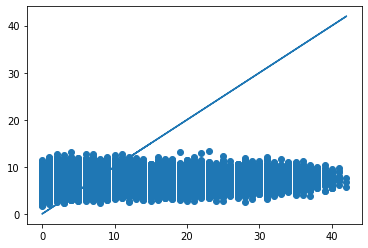

In [10]:
plt.plot(train[target], train[target])
plt.scatter(train[target], ctb_oof)

# Features importances

Text(0.5, 1.0, 'CatBoost feature importances')

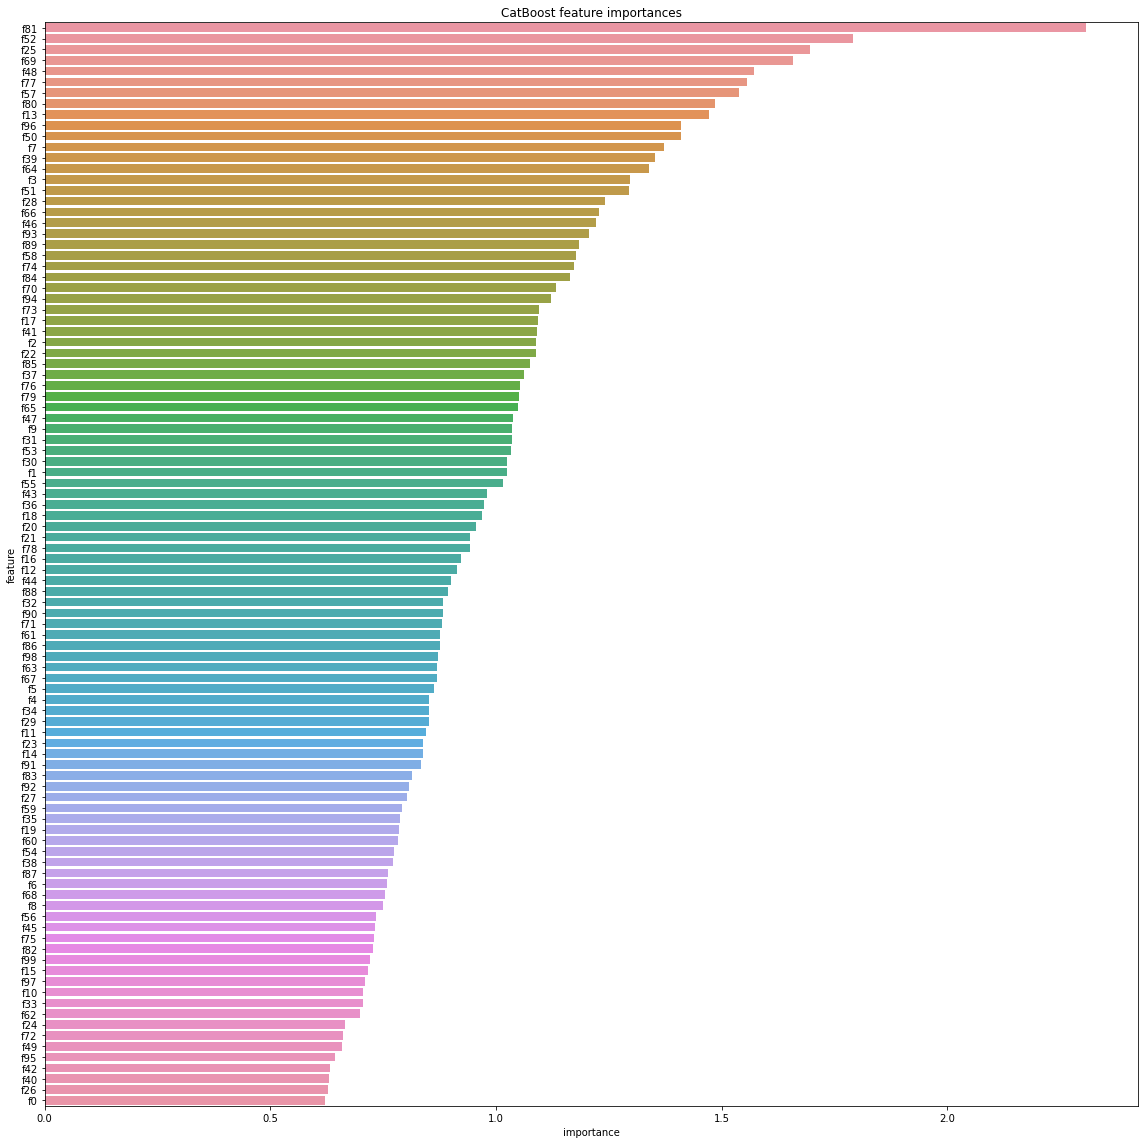

In [11]:
order = list(ctb_importances.groupby('feature').mean().sort_values('importance', ascending=False).index)

fig = plt.figure(figsize=(16, 16), tight_layout=True)
sns.barplot(x="importance", y="feature", data=ctb_importances.groupby('feature').mean().reset_index(), order=order)
plt.title("CatBoost feature importances")

# Submission

In [12]:
submission['loss'] = ctb_pred
submission.to_csv("submission.csv", index=False)

submission

,id,loss
0,250000,8.210572
1,250001,4.886986
2,250002,8.410812
3,250003,7.796551
4,250004,6.879712
...,...,...
149995,399995,7.765762
149996,399996,7.222719
149997,399997,6.406364
149998,399998,5.460397
